# Animal classification with the UCI Zoo Dataset

In this notebook, we'll attempt to develop a machine learning pipeline for classifying animals given several features. This pipeline will include EDA, data cleaning, algorithm selection, validation, and exploration of results, with explanations for each block of code.

We'll start with the basics, importing python packages we'll be using, as well as reading in the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

%matplotlib inline

In [2]:
zoo = pd.read_csv('zoo.csv')
class_link = pd.read_csv('class.csv')

## EDA

Let's do some exploratory data analysis first. The main things we're concerned with are class balance, feature correlation, and a basic "feature importance" visualization, shown by each predictor's relationship with the response. To start, let's examine the shape of the data.

In [3]:
zoo.shape

(101, 18)

Excluding the initial "animal_name" index variable, this means we have 17 total variables - 16 features and one response variable. Before proceeding, let's join the main zoo dataset with the class names in the secondary dataset, for ease of visualization.

In [4]:
class_link = class_link[['Class_Number','Class_Type']]
class_link.columns = ['class_type','class_name']
zoo = zoo.merge(class_link, left_on='class_type', right_on='class_type')

In [5]:
zoo.head()

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type,class_name
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1,Mammal
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1,Mammal
2,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1,Mammal
3,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1,Mammal
4,buffalo,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1,Mammal


Here's a quick histogram of the frequency of the response variable. We have a very imbalanced dataset, heavily represented by mammals and birds

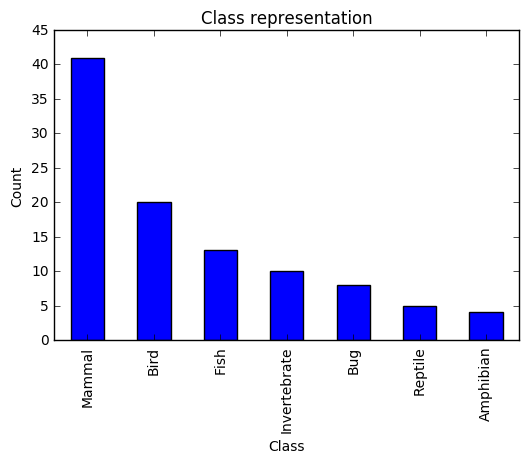

In [6]:
cls = zoo['class_name'].value_counts().plot(kind='bar', title='Class representation')
cls.set(xlabel="Class", ylabel="Count")

Let's now check out the pairwise correlation between our features. Since we have almost all boolean features, it's going to be tough to use a multicollinearity metric like VIF. Instead, let's just see if we have any extremely correlated features via pearson correlation.

([<matplotlib.axis.YTick at 0x18bbbf268d0>,
 <a list of 16 Text yticklabel objects>)

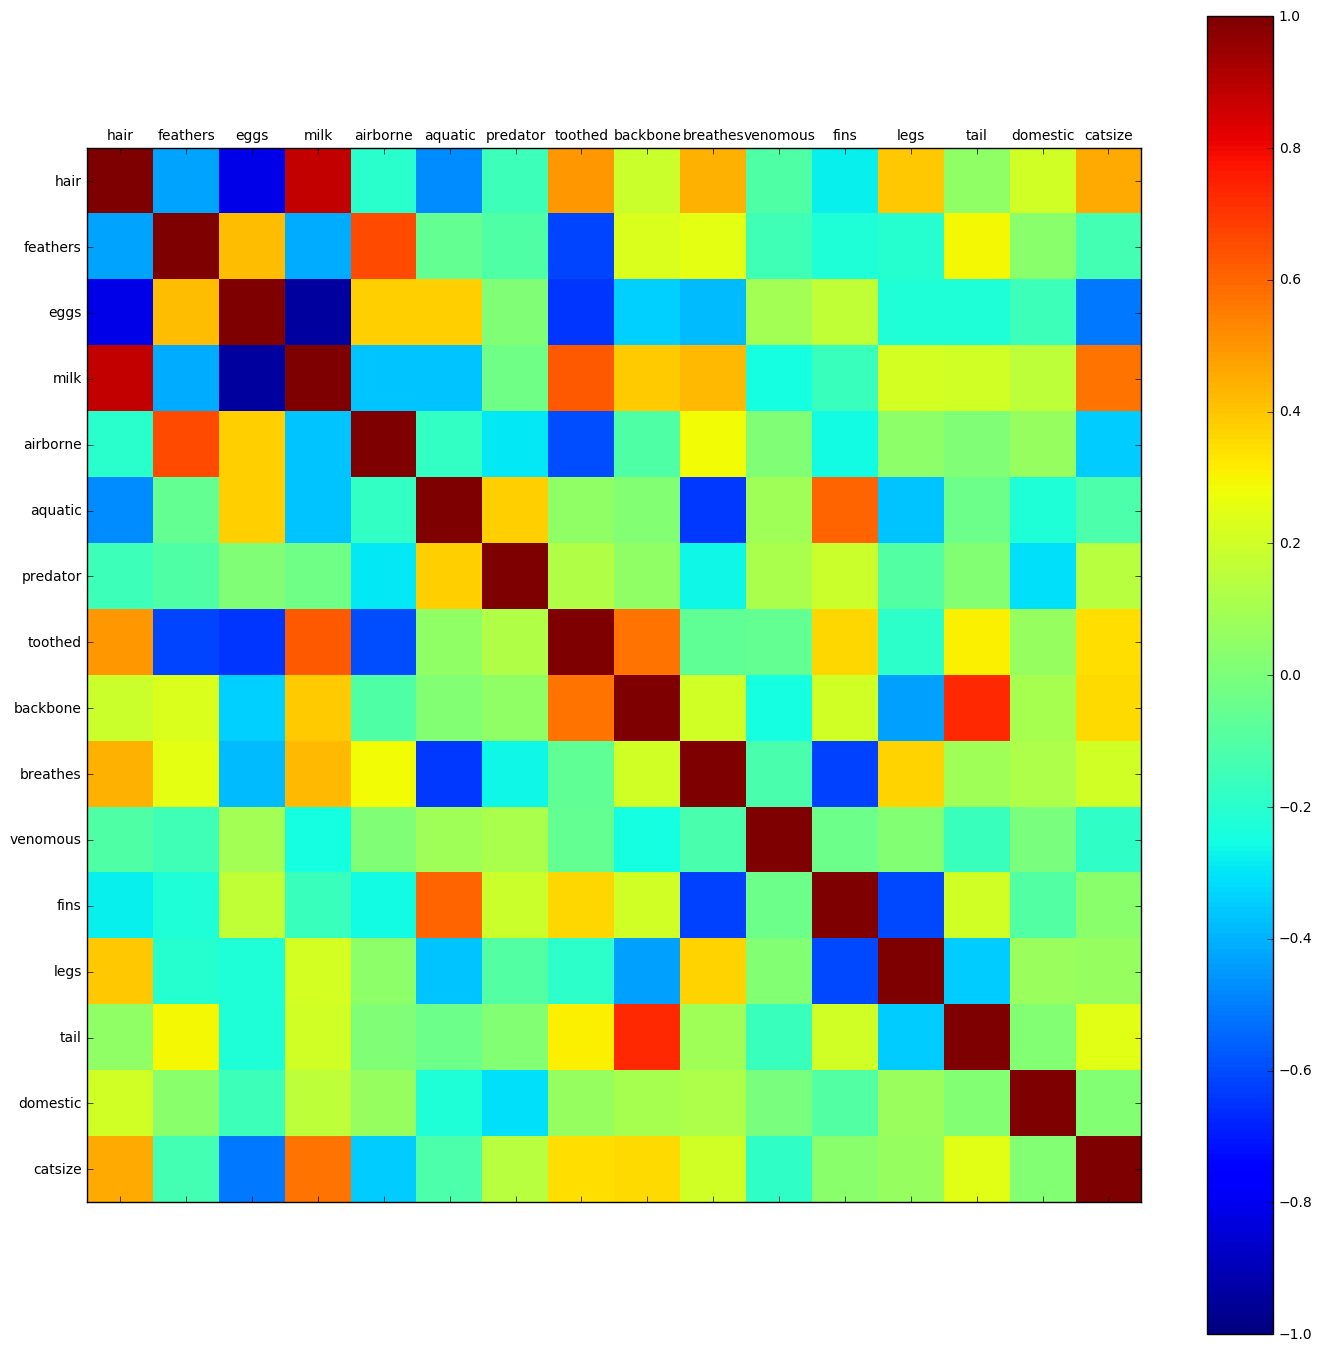

In [7]:
corr = zoo.iloc[:,1:17].corr()
fig, ax = plt.subplots(figsize=(17, 17))
ax.matshow(corr)
cax = ax.matshow(corr, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)

We do have some very highly correlated variables, notably a positive correlation between hair and milk, and a strong negative correlation between hair/milk and eggs. Since we shouldn't easily throw out any of these variables without having a clear indicator of singularity, we'll keep all variables for now. We may toss a few out if we use a linear method later.

Now let's see individual relationships between our predictors and response. We observe counts per class for all boolean variables and the mean per class for the numerical variable.

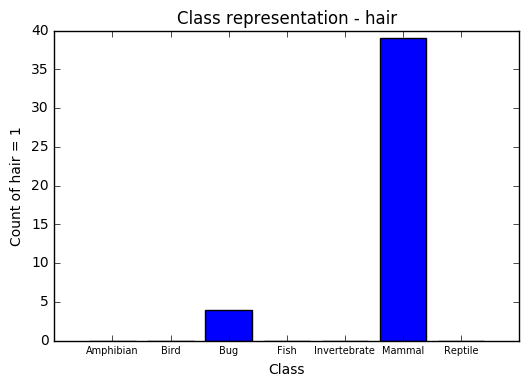

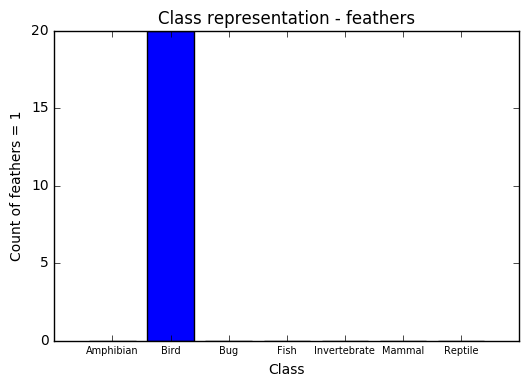

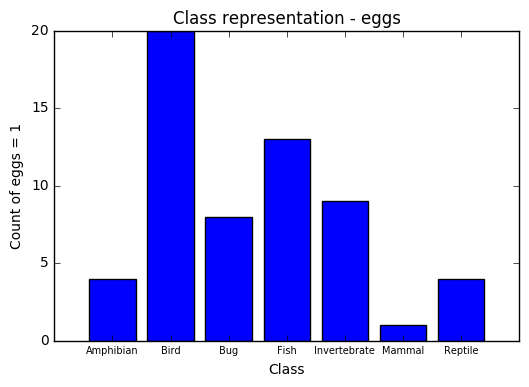

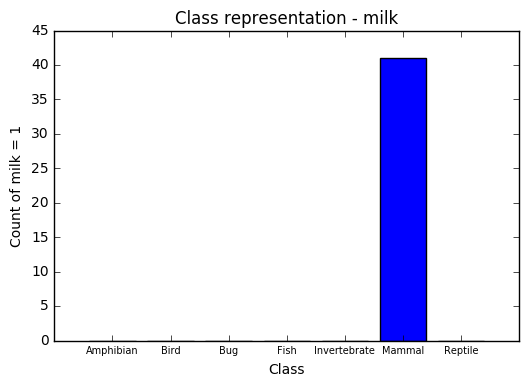

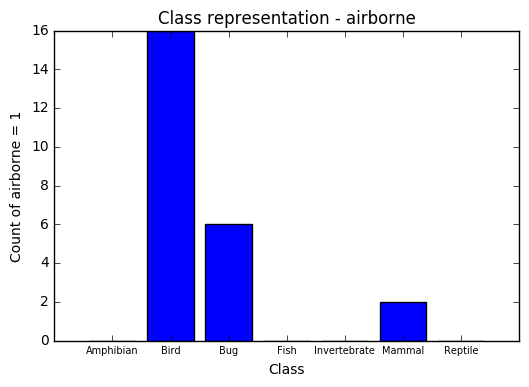

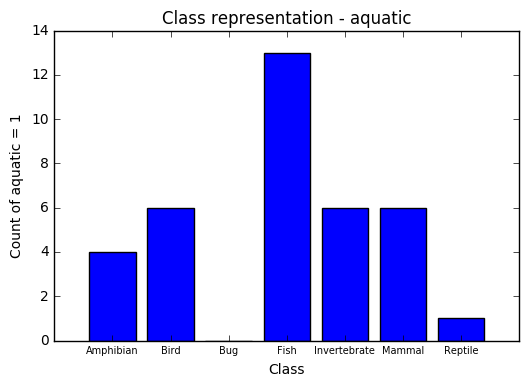

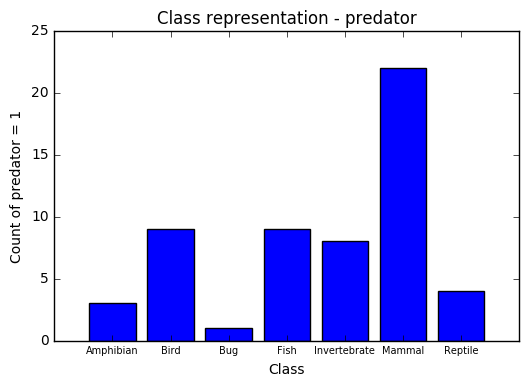

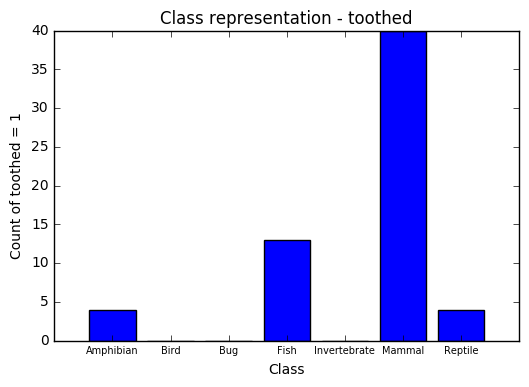

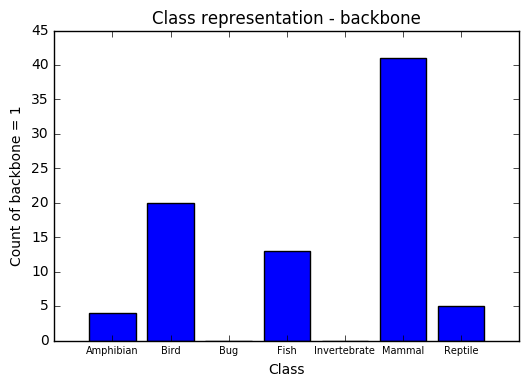

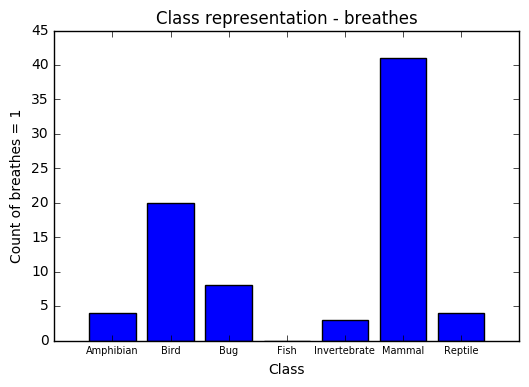

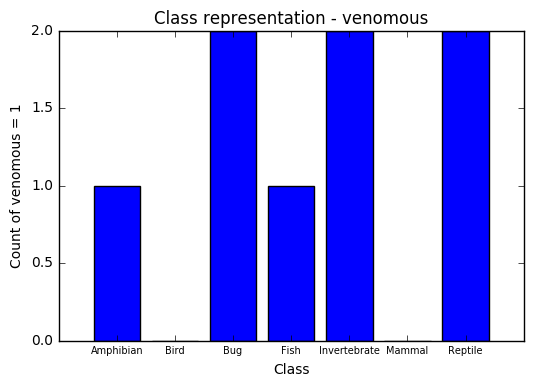

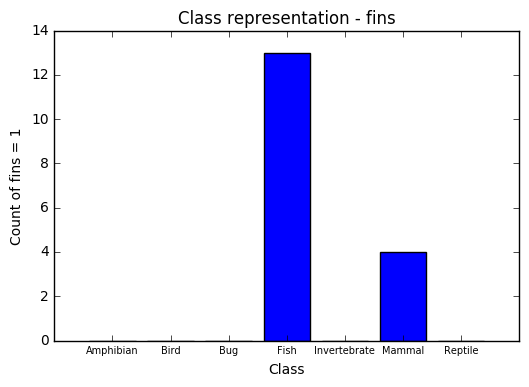

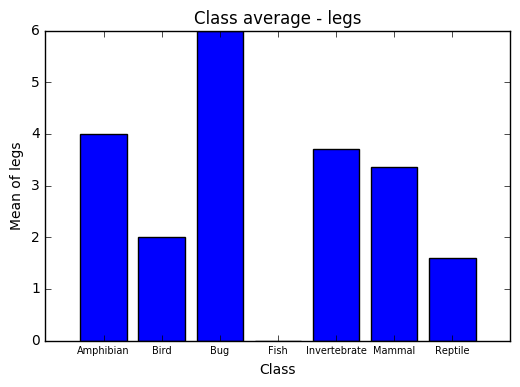

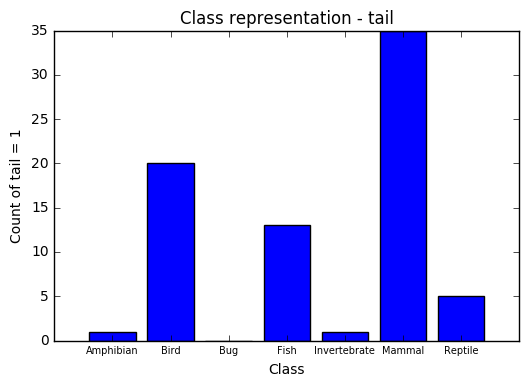

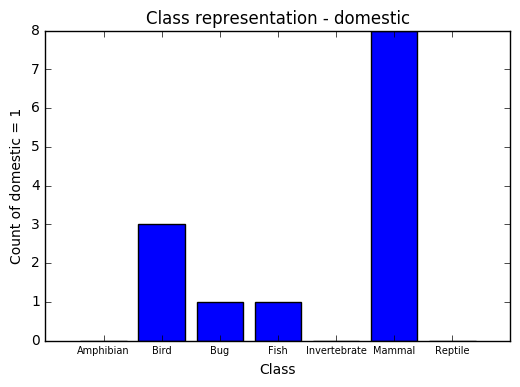

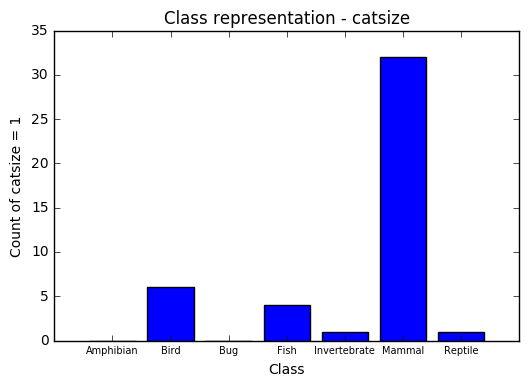

In [8]:
for item in zoo.columns[1:-2]:
    if item=='legs':
        x = zoo[[item,'class_name']].groupby('class_name').mean().reset_index()
        plt.bar(np.arange(7), x[item], align='center')
        plt.xticks(np.arange(7), x['class_name'], fontsize=7)
        plt.ylabel('Mean of %s' % item)
        plt.xlabel('Class')
        plt.title('Class average - %s' % item)
        plt.show()
        continue
    
    x = zoo[[item,'class_name']].groupby('class_name').sum().reset_index()
    plt.bar(np.arange(7), x[item], align='center')
    plt.xticks(np.arange(7), x['class_name'], fontsize=7)
    plt.ylabel('Count of %s = 1' % item)
    plt.xlabel('Class')
    plt.title('Class representation - %s' % item)
    plt.show()

Lots of variables here, but we can see immediately that a few variables are highly associated with one or two classes, and of those, some are exclusive to one class. E.g. only birds have feathers, only mammals have milk.

Given this information, it is tempting to create association rules to classify each data point, e.g. if milk==1 -> Mammal. However, doing this quickly gets out of hand when we consider interactions between the variables. Luckily for us, certain machine learning frameworks are very well suited to recognizing interactions between variables, namely decision trees.

But before we get to that, we should clean the data a bit more to make it suitable for input in our machine learning algorithms.

## Data Cleaning

This is already a very clean dataset, one that requires very little manipulation and no further feature engineering. We could try to be fancy and manually create interaction variables, e.g. if aquatic AND mammal then 1, but decision trees build these interactions into their structure.

The only "cleaning" we'll do here is coercing the binary variables to "boolean" and the response to "category". When preparing our data for input into our tree algorithm, we'll drop variables unnecessary for prediction.

In [9]:
zoo.iloc[:,1:13] = zoo.iloc[:,1:13].astype(bool)
zoo.iloc[:,14:17] = zoo.iloc[:,14:17].astype(bool)
zoo['class_type'] = zoo['class_type'].astype('category')

Here we prepare our data for input. The purpose of this split is for model validation. We want to find and tune a model which performs well on unseen data - the test set serves as our validation data to this end.

In [10]:
y = zoo['class_type']
X = zoo.drop(['animal_name','class_type', 'class_name'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model selection

As mentioned earlier, we'll go with tree based methods for this dataset. Not only does it make the most sense for our particular dataset, it's pretty much how taxonomy works. Higher classifications can be split into lower classifications like genus, species etc. using decision tree-esque rules. We'll attempt to model this relationship without actually knowing the rules.

To tune our models' parameters, we'll use cross validation on our training data. Accuracy metric for CV purposes will be macro averaged f1 score, which is the average f1 score for all individual classes (in an all vs one setting).

We'll start with a simple decision tree.

In [11]:
import warnings; warnings.simplefilter('ignore')
params = {'max_depth':[6,7,8],
         'min_samples_leaf':[1,2,3]}
model = DecisionTreeClassifier(random_state=42)
cv = GridSearchCV(model,params,scoring='f1_macro')
cv.fit(X_train,np.array(y_train))
print('Best parameters:',cv.best_params_)
print('Best CV score:',cv.best_score_)

Best parameters: {'min_samples_leaf': 1, 'max_depth': 6}
Best CV score: 0.8882251082251083


CV score is pretty good with the above parameters. Let's see what the result is on our held out data.

In [12]:
model = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 1)
model.fit(X_train,y_train)
preds = model.predict(X_test)
print('Accuracy is ', accuracy_score(y_test,preds))
print(classification_report(y_test,preds))

Accuracy is  0.8095238095238095
             precision    recall  f1-score   support

          1       1.00      1.00      1.00        10
          2       1.00      1.00      1.00         3
          3       0.00      0.00      0.00         1
          4       1.00      1.00      1.00         2
          5       0.50      1.00      0.67         1
          6       0.25      1.00      0.40         1
          7       0.00      0.00      0.00         3

avg / total       0.75      0.81      0.77        21



The model performs worse on the held out data than it did in CV, indicating we may have a problem with our data. As we saw earlier, the data is very imbalanced. Before we proceed to look at other models, there are a few things we can do to combat this imbalance.

## Resampling data

In this exercise, we have a very limited dataset which is hampering our ability to create a model which generalizes well. Adding to that, the imbalanced class representation is making it difficult for our model to learn the relationship between the features and minority classes.

The first approach is getting more data. I should note that this approach will very rarely work in real life, as extra data is usually hard to come by. However, in our case, there are more than 101 species of animals in the world, so it's not too tough to do a bit of research and get more data.

In a more realistic scenario, we may have to resort to artificially resampling our data via upsampling and downsampling. Downsampling would be quite easy in our case, as we'd just have to remove a bunch of samples from the "Mammal" class. While that could be effective, we already have such a tiny dataset that it may harm our models' ability to generalize. What we'll do instead is upsample the minority classes in the training data.

First, let's load in our larger dataset, a result of a bit of research.

In [13]:
zoo = pd.read_csv('zoo2.csv')
zoo.shape

(144, 18)

Same variables as the previous dataset, but now we have 144 data points rather than 101. Let's relink the class names and check out the new class representations.

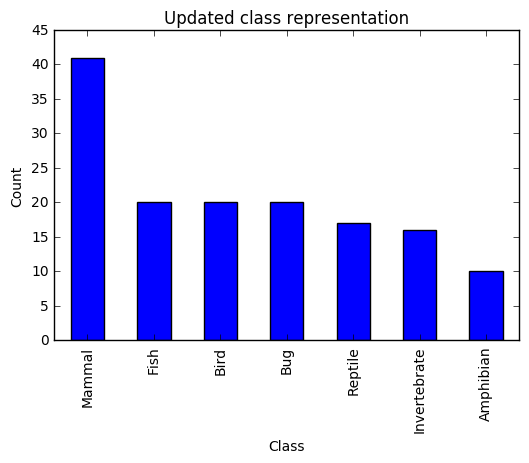

In [14]:
zoo = zoo.merge(class_link, left_on='class_type', right_on='class_type')
cls = zoo['class_name'].value_counts().plot(kind='bar', title='Updated class representation')
cls.set(xlabel="Class", ylabel="Count")

Looks much better, albeit still imbalanced in favor of mammals. We'll now proceed up through the train/test split.

In [15]:
zoo.iloc[:,1:13] = zoo.iloc[:,1:13].astype(bool)
zoo.iloc[:,14:17] = zoo.iloc[:,14:17].astype(bool)
zoo['class_type'] = zoo['class_type'].astype('category')
y = zoo['class_type']
X = zoo.drop(['animal_name','class_type', 'class_name'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now we'll artificially upsample the training data only to avoid data leakage into the test set. That is, we will avoid having the same (or very slightly perturbed) data points in the training/test sets, which will artificially increase the accuracy of our model.

We'll be using SMOTE, a type of synthetic minority upsampling. We'll set the desired class ratio to .75, since we don't want too much synthetic data.

Note that in a scenario with a bigger training set that you're performing CV on, you'd want to incorporate SMOTE into your CV shell, to avoid inflating your CV scores with synthetic data. In our case, the data is small enough that it doesn't end up making a difference.

In [16]:
sm = SMOTE(random_state=42, ratio = .75)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [17]:
from scipy.stats import itemfreq
itemfreq(y_train_res)

array([[ 1, 33],
       [ 2, 24],
       [ 3, 24],
       [ 4, 24],
       [ 5, 24],
       [ 6, 24],
       [ 7, 24]], dtype=int64)

Now our classes are much more balanced. Let's try our model selection again.

## Models pt. 2

Decision Tree

In [18]:
warnings.simplefilter('ignore')
params = {'max_depth':[5,6,7],
         'min_samples_leaf':[1,2,3]}
model = DecisionTreeClassifier(random_state=42)
cv = GridSearchCV(model,params,scoring='f1_macro')
cv.fit(X_train_res,np.array(y_train_res))
print('Best parameters:',cv.best_params_)
print('Best CV score:',cv.best_score_)

Best parameters: {'min_samples_leaf': 1, 'max_depth': 7}
Best CV score: 0.9759548263749945


In [19]:
model = DecisionTreeClassifier(max_depth = 7, min_samples_leaf = 1)
model.fit(X_train_res,y_train_res)
preds = model.predict(X_test)
print('Accuracy is ', accuracy_score(y_test,preds))
print(classification_report(y_test,preds))
print(confusion_matrix(y_test,preds))

Accuracy is  0.9310344827586207
             precision    recall  f1-score   support

          1       1.00      1.00      1.00         8
          2       1.00      1.00      1.00         6
          3       0.50      0.50      0.50         2
          4       1.00      1.00      1.00         4
          5       0.67      0.67      0.67         3
          6       1.00      1.00      1.00         4
          7       1.00      1.00      1.00         2

avg / total       0.93      0.93      0.93        29

[[8 0 0 0 0 0 0]
 [0 6 0 0 0 0 0]
 [0 0 1 0 1 0 0]
 [0 0 0 4 0 0 0]
 [0 0 1 0 2 0 0]
 [0 0 0 0 0 4 0]
 [0 0 0 0 0 0 2]]


Much better! Precision, recall, f1, and accuracy are all around 93%. We also see through the confusion matrix that the model only made two incorrect predictions - It predicted a true amphibian as a reptile, and a true reptile as an amphibian. Let's see if we can do a better job with ensemble models.

Random Forest

In [20]:
warnings.simplefilter('ignore')
params = {'max_depth':[5,6,7],
         'min_samples_leaf':[1,2,3],
         'n_estimators':[100,300,700],
         'max_features':[3,4,5,6]}
model = RandomForestClassifier(random_state=42)
cv = GridSearchCV(model,params,scoring='f1_macro')
cv.fit(X_train_res,np.array(y_train_res))
print('Best parameters:',cv.best_params_)
print('Best CV score:',cv.best_score_)

Best parameters: {'min_samples_leaf': 1, 'n_estimators': 100, 'max_depth': 5, 'max_features': 3}
Best CV score: 0.9820728291316527


In [21]:
model = RandomForestClassifier(max_depth=5, min_samples_leaf=1, n_estimators=100, max_features=3, random_state=42)
model.fit(X_train_res,y_train_res)
preds = model.predict(X_test)
print('Accuracy is ', accuracy_score(y_test,preds))
print(classification_report(y_test,preds))
print(confusion_matrix(y_test,preds))

Accuracy is  0.9655172413793104
             precision    recall  f1-score   support

          1       1.00      1.00      1.00         8
          2       1.00      1.00      1.00         6
          3       0.67      1.00      0.80         2
          4       1.00      1.00      1.00         4
          5       1.00      0.67      0.80         3
          6       1.00      1.00      1.00         4
          7       1.00      1.00      1.00         2

avg / total       0.98      0.97      0.97        29

[[8 0 0 0 0 0 0]
 [0 6 0 0 0 0 0]
 [0 0 2 0 0 0 0]
 [0 0 0 4 0 0 0]
 [0 0 1 0 2 0 0]
 [0 0 0 0 0 4 0]
 [0 0 0 0 0 0 2]]


Better than a simple decision tree. This model only misclassifies one data point.

Let's try gradient boosted trees.

In [22]:
warnings.simplefilter('ignore')
params = {'learning_rate':[.005,.01,.05],
         'n_estimators':[1000,1500,2000],
         'max_depth':[4,5,6]}
model = GradientBoostingClassifier(random_state=42)
cv = GridSearchCV(model,params,scoring='f1_macro')
cv.fit(X_train_res,np.array(y_train_res))
print('Best parameters:',cv.best_params_)
print('Best CV score:',cv.best_score_)

Best parameters: {'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 4}
Best CV score: 0.9756738667224601


In [23]:
model = GradientBoostingClassifier(learning_rate = .01, n_estimators=1000, max_depth=4)
model.fit(X_train_res,y_train_res)
preds = model.predict(X_test)
print('Accuracy is ', accuracy_score(y_test,preds))
print(classification_report(y_test,preds))
print(confusion_matrix(y_test,preds))

Accuracy is  0.9310344827586207
             precision    recall  f1-score   support

          1       1.00      1.00      1.00         8
          2       1.00      1.00      1.00         6
          3       0.50      0.50      0.50         2
          4       1.00      1.00      1.00         4
          5       0.67      0.67      0.67         3
          6       1.00      1.00      1.00         4
          7       1.00      1.00      1.00         2

avg / total       0.93      0.93      0.93        29

[[8 0 0 0 0 0 0]
 [0 6 0 0 0 0 0]
 [0 0 1 0 1 0 0]
 [0 0 0 4 0 0 0]
 [0 0 1 0 2 0 0]
 [0 0 0 0 0 4 0]
 [0 0 0 0 0 0 2]]


Gradient boosted trees do not work as well as random forests in this case, misclassifying two points in the test set. One possible explanation is that the relationship between the features and response is in fact a complex interaction, which cannot be picked up by the weak learners comprising the model.

Lastly, just for completeness' sake, we'll try a logistic regression.

In [24]:
warnings.simplefilter('ignore')
params = {'C':[.01,.05,.1,.5,1]}
model = LogisticRegression(random_state=42)
cv = GridSearchCV(model,params,scoring='f1_macro')
cv.fit(X_train_res,np.array(y_train_res))
print('Best parameters:',cv.best_params_)
print('Best CV score:',cv.best_score_)

Best parameters: {'C': 0.5}
Best CV score: 0.981930549997777


In [25]:
model = LogisticRegression(C=0.5)
model.fit(X_train,y_train)
preds = model.predict(X_test)
print('Accuracy is ', accuracy_score(y_test,preds))
print(classification_report(y_test,preds))

Accuracy is  0.9655172413793104
             precision    recall  f1-score   support

          1       1.00      1.00      1.00         8
          2       1.00      1.00      1.00         6
          3       0.67      1.00      0.80         2
          4       1.00      1.00      1.00         4
          5       1.00      0.67      0.80         3
          6       1.00      1.00      1.00         4
          7       1.00      1.00      1.00         2

avg / total       0.98      0.97      0.97        29



This performs just as well as our random forest.

Now let's visualize our decision tree.

## Tree Visualization

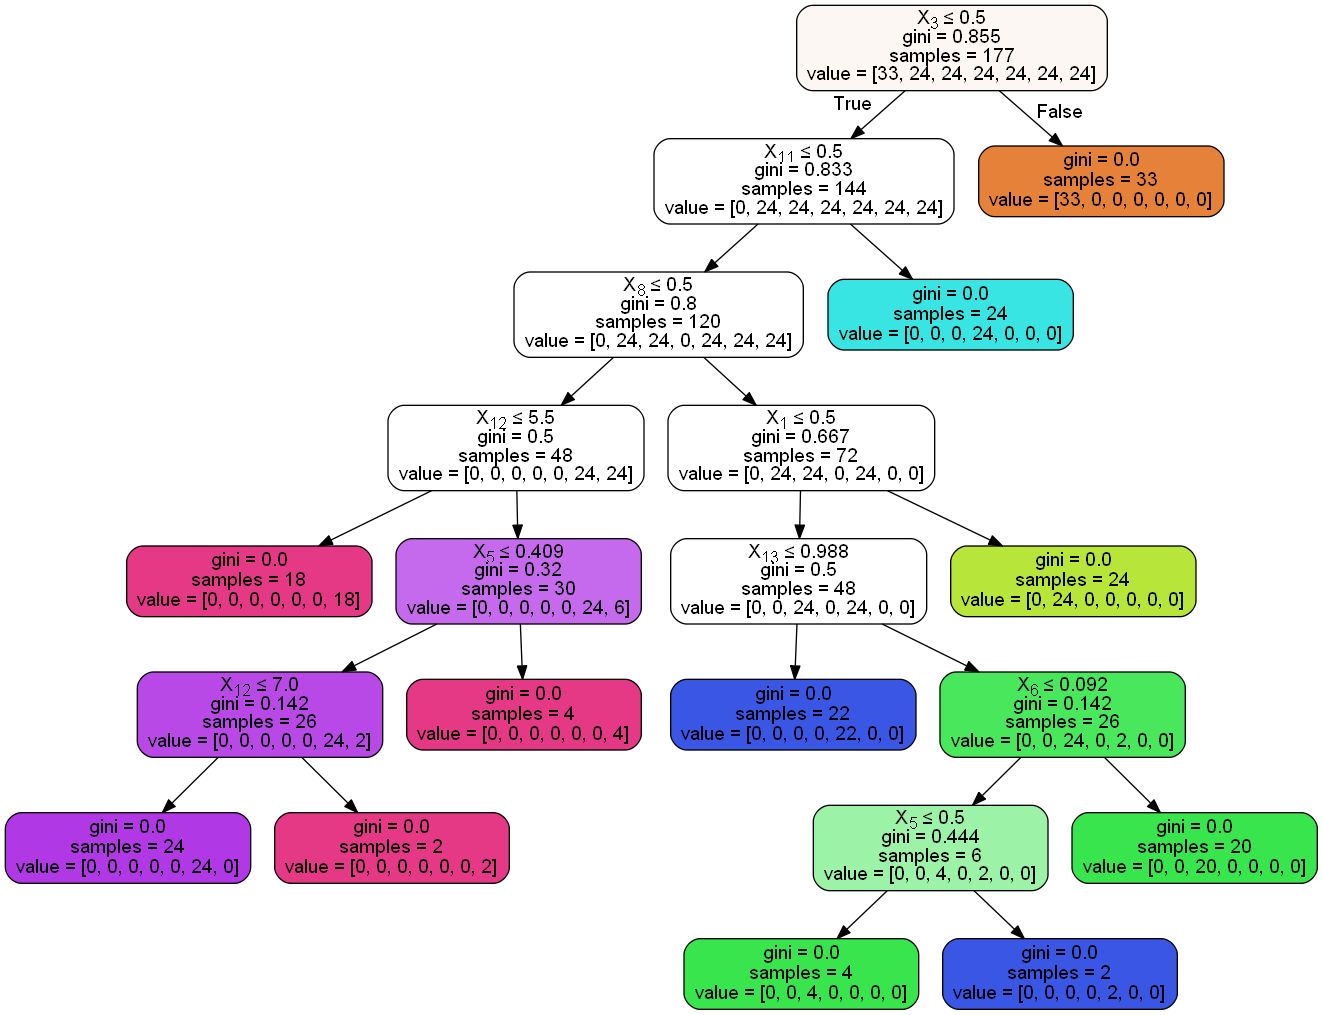

In [26]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

model = DecisionTreeClassifier(max_depth = 7, min_samples_leaf = 1)
model.fit(X_train_res,y_train_res)

dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

We have 10 terminal nodes, all of which contain only one class, which aligns with our assumption that a decision tree accurately models the process of taxonomy.

Just for fun, let's see what kind of predictions our model spits out.

## Model Output

In [27]:
preds = model.predict(X)
zoo2 = zoo.join(pd.Series(preds).rename('predictions'))
zoo2[zoo2['class_type'] != zoo2['predictions']]

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type,class_name,predictions
119,newt,False,False,True,False,False,True,True,True,True,True,False,False,4,True,False,False,5,Amphibian,3
132,turtle,False,False,True,False,False,True,False,False,True,True,False,False,4,True,True,True,3,Reptile,5


It looks like our decision tree was unable to correctly classify two data points, one true amphibian and one true reptile. The crossover between these two classes is very high. Perhaps in future work, we can do some more research to find the true features which distinguish closely related classes like these.